# SRM + STDP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Model

In [82]:
INPUT_SIZE, OUTPUT_SIZE = 20, 2
DELAY_MIN, DELAY_MAX = 1, 7
THRESHOLD = 1
INPUT_REPEAT = 5  # [5, 10].
T = 100  # Time.
TAU = 1
T_S = 1

In [112]:
class SRM:
    def __init__(
        self,
        hidden_size,
        input_size=INPUT_SIZE,
        output_size=OUTPUT_SIZE,
        t_max=T * INPUT_REPEAT,
        delay_span=(DELAY_MIN, DELAY_MAX),
        threshold=THRESHOLD,
        tau=TAU,
        t_s=T_S,
    ):
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.t_max = t_max
        self.threshold = threshold
        self.tau = tau
        self.t_s = t_s

        self.w1 = np.random.rand(input_size, hidden_size)
        self.w2 = np.random.rand(hidden_size, output_size)
        delay_min, delay_max = delay_span
        self.d1 = np.random.randint(delay_min, delay_max + 1, size=(input_size, hidden_size))
        self.d2 = np.random.randint(delay_min, delay_max + 1, size=(hidden_size, output_size))    

    def __call__(self, u_input):
        if u_input.shape != (self.t_max, self.input_size):
            raise ValueError('Wrong input shape for model params!')
        self.u_hidden = np.zeros((self.t_max, self.hidden_size))
        self.u_output = np.zeros((self.t_max, self.output_size))

        self.f_hidden = np.zeros((self.t_max, self.hidden_size))
        self.f_output = np.zeros((self.t_max, self.output_size))

        self.tp_input = np.zeros((self.input_size))
        self.tp_hidden = np.zeros((self.hidden_size))
        self.tp_output = np.zeros((self.output_size))
        for t in range(self.t_max):
            self.u_hidden[t] = self.u(t, self.tp_hidden, self.d1, self.w1, self.tp_input)
            self.u_output[t] = self.u(t, self.tp_output, self.d2, self.w2, self.tp_hidden)
            
            self.f_hidden[t] = (self.u_hidden[t] > self.threshold).astype(int)
            self.f_output[t] = (self.u_output[t] > self.threshold).astype(int)
            
            self.tp_input = self.tp(self.tp_input, u_input, t)
            self.tp_hidden = self.tp(self.tp_hidden, self.f_hidden, t)
            self.tp_output = self.tp(self.tp_output, self.f_output, t)
            
            self.w1 = self.w(self.w1, self.tp_input, t)
            self.w2 = self.w(self.w2, self.tp_hidden, t)

        return self.u_output
    
    def u(self, t, last_t, d, w, p_last_t):
        def eta(s):
            return -self.threshold * np.exp(-s / self.tau) * np.heaviside(s, 0)
        
        def eps(s):
            return s / self.t_s * np.exp(-s / self.t_s) * np.heaviside(s, 0)
        
        return eta(t - last_t) + np.sum(w * eps((t - p_last_t - d.T).T), axis=0)
    
    def tp(self, tp, spikes, t):
        return np.maximum(tp, spikes[t] * t)
    
    def w(self, w, tp, t):
        return w

## SRM

In [128]:
def plot(u, u2=None):
    n = u.shape[1]
    time = np.arange(u.shape[0])
    
    plt.figure(figsize=(15, 2 * n))
    
    for i in range(n):
        plt.subplot(n, 1, i + 1)
        plt.plot(time, u[:, i])
        if u2 is not None:
            plt.plot(time, u2[:, i])
        plt.xlabel('time')
        plt.ylabel('u(t)')
    plt.show()

In [123]:
def generate_x1(k):
    spikes = np.zeros((10 * T,))
    t = 0
    while (t < T):
        t += int(-np.log(1.0 - np.random.rand()) / k) + 1
        spikes[t] = 1

    return spikes[:T]


def generate_input(k=0.9):
    x = np.array([generate_x1(k) for _ in range(INPUT_SIZE)])
    x = np.repeat(x, INPUT_REPEAT, axis=1).T
    return x


def noise(x, p=0.05):
    return np.where(np.random.uniform(size=x.shape) < p, 1, x)


x1, x2 = generate_input(0.9), generate_input(0.95)  # Patterns.
x1_noise, x2_noise = noise(x1), noise(x2)
x1.shape, x2.shape

((500, 20), (500, 20))

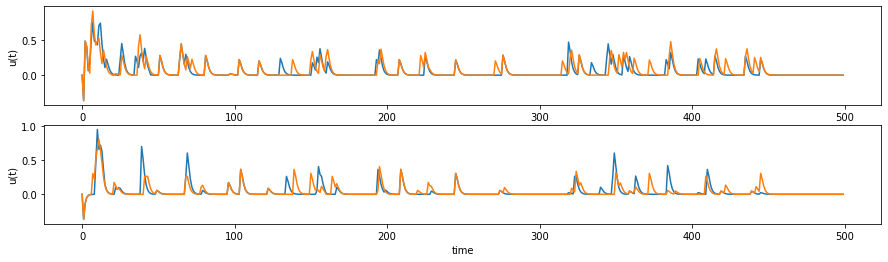

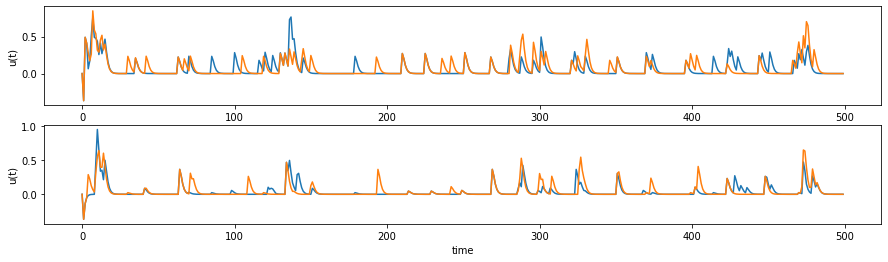

In [130]:
model = SRM(10)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

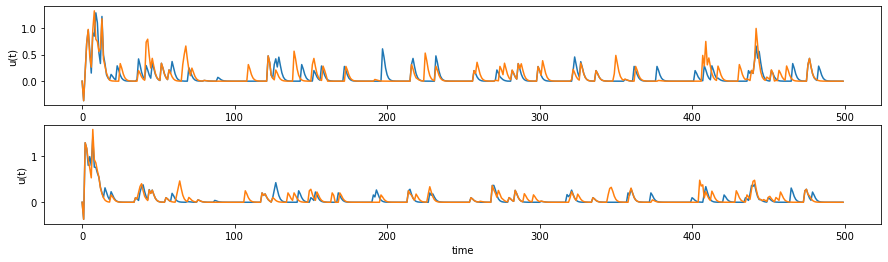

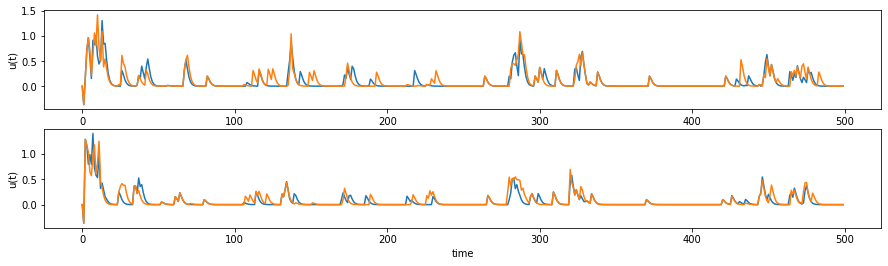

In [132]:
model = SRM(20)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

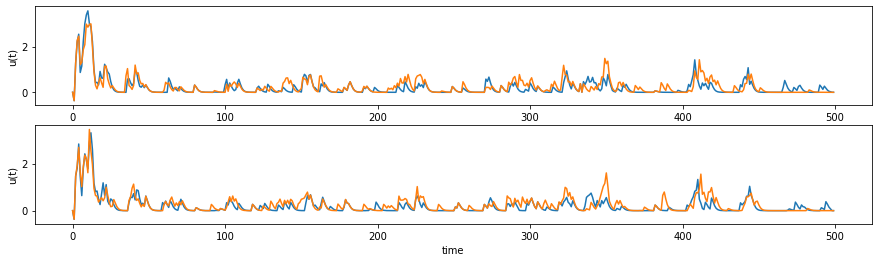

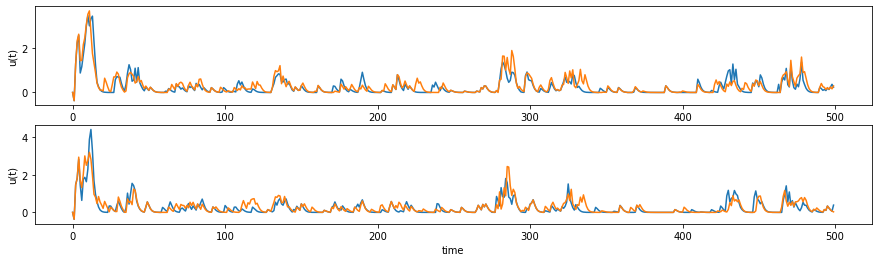

In [133]:
model = SRM(50)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

## STDP

In [117]:
class STDP(SRM):
    def w(self, w, tp, t):
        w = w.copy()
        for i in range(w.shape[0]):
            for j in range(w.shape[1]):
                w[i, j] += self._stdp_func(w[i, j], t - tp[i])

        return w
    
    def _stdp_func(self, w, t):
        c1 = 0.5  # w-value on head of red rectangle
        t1 = 20  # t-value on head of red rectangle
        c2 = -0.2  # w-value on head of blue rectangle
        t2 = -5  # t-value on head of blue rectangle
        const1 = 0.01  # increasing constant for windows with LTD
        const2 = 0.01  # decreasing constant for windows with LTP
        
        if t == 0:
            return 0.0

        if ((t < t1 and w < t * c1 / 20) or (t1 <= t < 20 and w < -t * c1 / 20 + 20)) and w > 0:
            return const1
        if ((t > t2 and w > t * c2 / 5) or (t2 <= t < 100 and w > -t * c2 / 50 - 100)) and w < 0:
            return -const2

        return 0.0

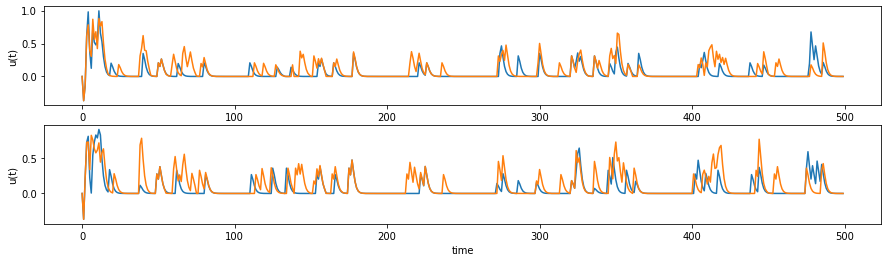

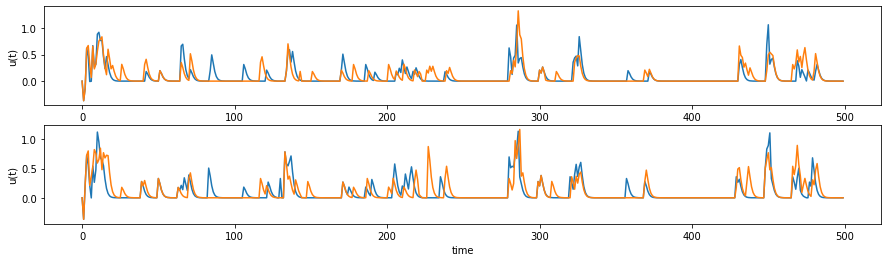

In [131]:
model = STDP(10)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)